# SpectralNET: Hiperspektral Görüntü Sınıflandırması için Uzamsal Spektral Dalgacık dönüşümlü ESA modeli 

**Düzenleyen:** Oğuzhan AZAKLIOĞLU**

In [1]:
## Gerekli kütüphanelerin çağırılması

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model

 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
## Boyut indirgeme yöntemi olan FA'nın fonksiyon tanımı
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

# Verilerin yüklenmesi

In [3]:
## Global Değikenler (inputlar)
dataset = 'IP'
test_ratio = 0.75
windowSize = 24

In [4]:
## Veri kümesinin çağrılması

def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [5]:
## Veri kümesini eğitim ve test olarak ayırmaya yarayan fonksiyon

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
## Padding Fonksiyonu

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [7]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
## veri kümesinin boyutları 

X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
K = X.shape[2]

In [10]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(145, 145, 3)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 24, 24, 3), (10249,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2562, 24, 24, 3), (7687, 24, 24, 3), (2562,), (7687,))

# Model ve Eğitim Aşaması

In [13]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2562, 24, 24, 3, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(2562, 16)

In [15]:
S1 = windowSize
L1 = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [16]:
## Dalgacık dönüşüm fonksiyonunun tanımlanması

def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [17]:
##Dalgacık fonksiyonunun tanımlanması

def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [18]:
img_batch = Kb.zeros(shape=(8, 24, 24, 3), dtype='float32')
Wavelet(img_batch)

[<tf.Tensor: shape=(8, 12, 12, 12), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

In [19]:
## ESA modelinin katmanları ve tanımlanması

def get_wavelet_cnn_model():
 
    input_shape =  24, 24, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    
    # ayrışma katmanı 1 başlıyor
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)
 
    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)
 
    # ayrışma katmanı 2 başlıyor
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
 
    # birleştirme katmanı 1 ve ayrışma katmanı 2 
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
 
    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)
 
    # ayrışma katmanı 3 başlıyor
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
 
    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)
 
    # birleştirme katmanı 2 ve ayrışma katmanı 3 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)
 
    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)
 
    # dördüncü seviye ayrıştırmanın başlaması
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
 
    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)
 
    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)
 
    # birleştirme katmanı 3 ve ayrışma katmanı 4 
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
 
    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)
 
    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
 
    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
 
    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)
 
    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)
 
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
 
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')
 
    return model

In [20]:
model = get_wavelet_cnn_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 wavelet (Lambda)               [(None, 12, 12, 12)  0           ['the_input[0][0]']              
                                , (None, 6, 6, 12),                                               
                                 (None, 3, 3, 12),                                                
                                 (None, 2, 2, 12)]                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 12, 12, 64)   6976        ['wavelet[0][0]']            

In [21]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [22]:
## elde edilen modelin sonra kullanmak üzere saklanması için dosya yolu belirlenmesi

filepath = (str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [23]:
## modelin eğitilmesi

history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=40, callbacks=callbacks_list)

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 1.2145 - accuracy: 0.6315
Epoch 1: saving model to IP_0.75_best_model.hdf5
86/86 [==============================] - 12s 38ms/step - loss: 1.2145 - accuracy: 0.6315
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8763
Epoch 2: saving model to IP_0.75_best_model.hdf5
86/86 [==============================] - 3s 32ms/step - loss: 0.4289 - accuracy: 0.8763
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9500
Epoch 3: saving model to IP_0.75_best_model.hdf5
86/86 [==============================] - 2s 29ms/step - loss: 0.1925 - accuracy: 0.9500
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9657
Epoch 4: saving model to IP_0.75_best_model.hdf5
86/86 [==============================] - 2s 28ms/step - loss: 0.1245 - accuracy: 0.9657
Epoch 5/40
86/86 [==============================] - ETA: 0s - loss: 0.1618 

In [24]:
model.save(str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")

# Sınıflandırma sonuçlarının gözlemlenmesi

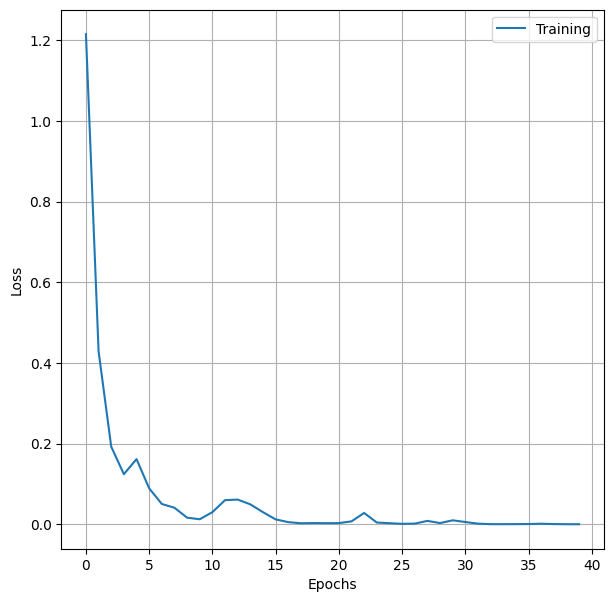

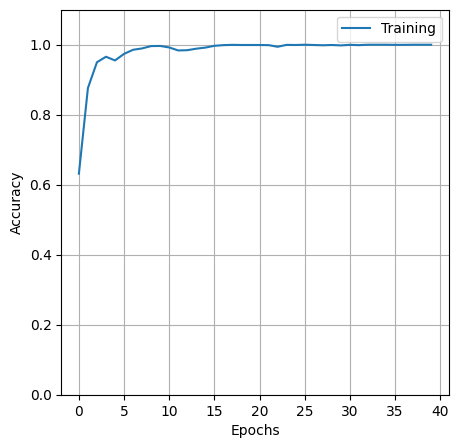

In [25]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(str(dataset)+"_"+str(test_ratio)+"_loss_curve.jpg")
plt.show()
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(str(dataset)+"_"+str(test_ratio)+"_acc_curve.jpg") 
plt.show()

In [26]:
# önceden kaydedilen modelin dosya yolundan çekilmesi

model.load_weights(str(dataset)+"_"+str(test_ratio)+"_best_model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [27]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7687, 24, 24, 3, 1)

In [28]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7687, 16)

In [29]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
 
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification_report)

241/241 [==============================] - 6s 16ms/step
<function classification_report at 0x0000022BE378C4C0>


In [30]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [31]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [32]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

241/241 [==============================] - 7s 18ms/step - loss: 0.0102 - accuracy: 0.9977


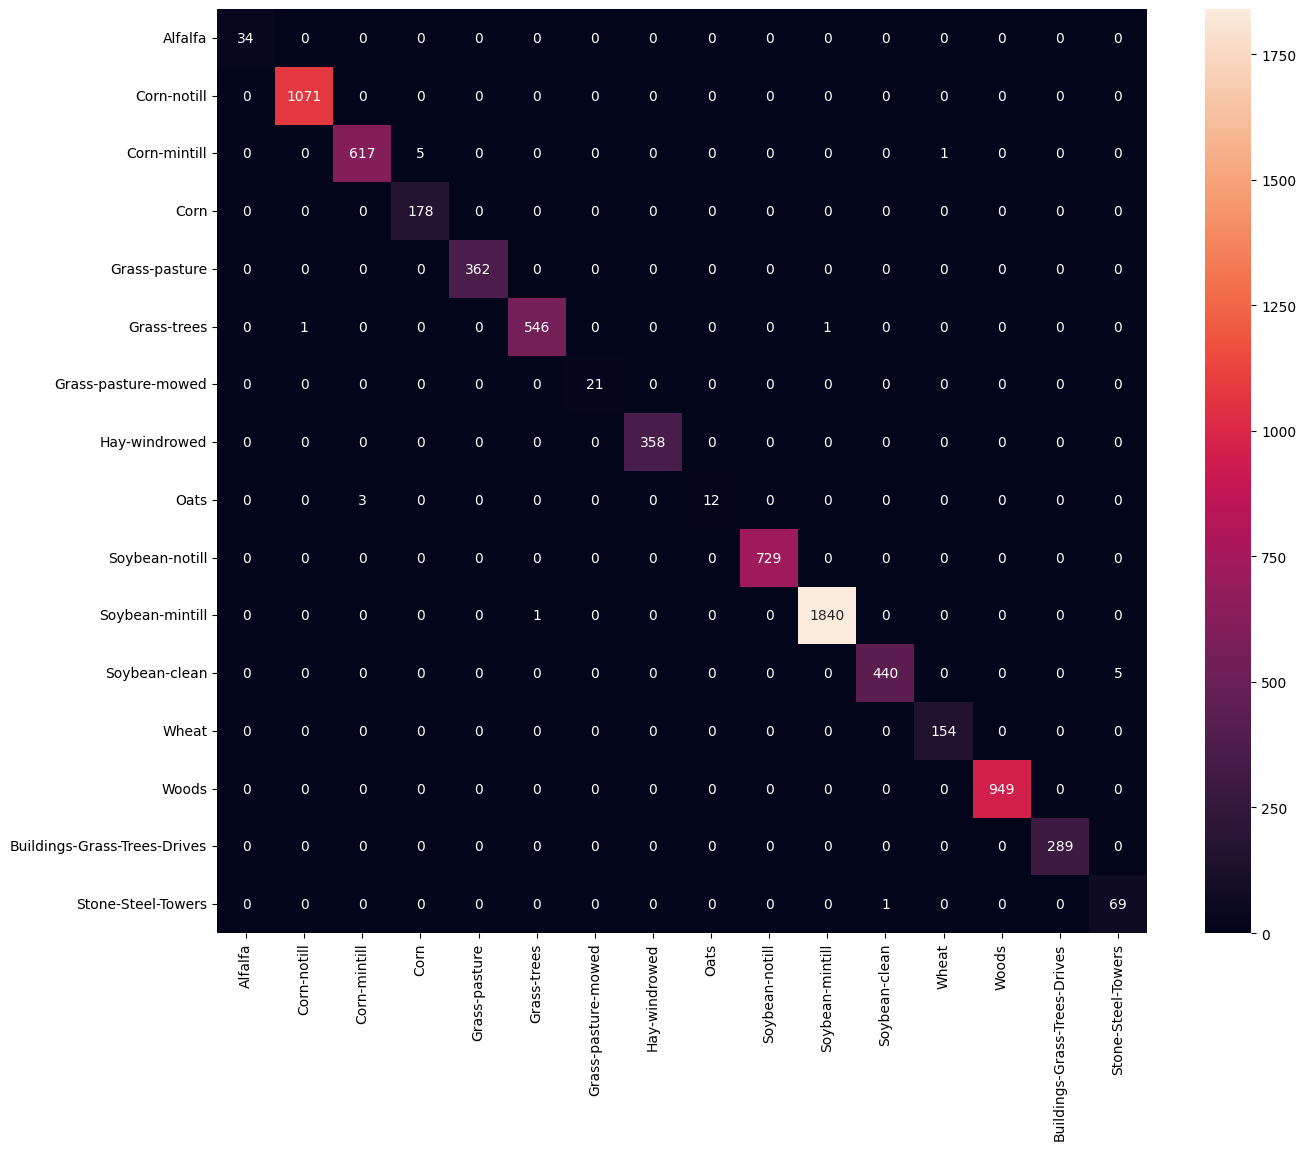

In [33]:
##Confusion matrix çizdirme

plt.figure(figsize = (15,12))

classes = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

df_cm = pd.DataFrame(confusion, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.savefig(str(dataset)+"_"+str(test_ratio)+"_ConfMatrix.jpg", dpi=100)
plt.show()

In [34]:
classification = str(classification)
confusion = str(confusion)
file_name = str(dataset)+"_"+str(test_ratio)+"_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [35]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [36]:
# orjinal görüntüyü yükleme
X, y = loadData(dataset)

In [37]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [38]:
K = 3
X,fa = applyFA(X, numComponents=K)


In [39]:
X = padWithZeros(X, PATCH_SIZE//2)

In [40]:
# sınıflandırma sonucunda oluşan görselin hesaplanması


outputs = np.zeros((height,width))
for i in tqdm(range(height), desc="Predictting...", ascii=False, ncols=75):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Predictting...:   0%|                              | 0/145 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Predictting...:   1%|▏                     | 1/145 [00:05<13:46,  5.74s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:   1%|▎                     | 2/145 [00:11<14:18,  6.00s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:   2%|▍                     | 3/145 [00:17<14:08,  5.98s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:   3%|▌                     | 4/145 [00:23<13:46,  5.86s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:   3%|▊                     | 5/145 [00:29<13:34,  5.82s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:   4%|▉                     | 6/145 [00:34<13:09,  5.68s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:   5%|█                     | 7/145 [00:41<13:35,  5.91s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:   6%|█▏                    | 8/145 [00:47<13:54,  6.09s/it]

1/1 [==============================] - 0s 48ms/step


Predictting...:   6%|█▎                    | 9/145 [00:54<14:25,  6.36s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:   7%|█▍                   | 10/145 [01:01<14:50,  6.59s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:   8%|█▌                   | 11/145 [01:08<14:35,  6.54s/it]

1/1 [==============================] - 0s 46ms/step


Predictting...:   8%|█▋                   | 12/145 [01:14<14:20,  6.47s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:   9%|█▉                   | 13/145 [01:21<14:21,  6.52s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  10%|██                   | 14/145 [01:28<14:49,  6.79s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  10%|██▏                  | 15/145 [01:34<14:14,  6.57s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  11%|██▎                  | 16/145 [01:40<13:41,  6.37s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  12%|██▍                  | 17/145 [01:45<12:52,  6.04s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  12%|██▌                  | 18/145 [01:52<13:18,  6.28s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  13%|██▊                  | 19/145 [01:58<12:58,  6.18s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  14%|██▉                  | 20/145 [02:04<12:58,  6.23s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  14%|███                  | 21/145 [02:10<12:41,  6.14s/it]

1/1 [==============================] - 0s 46ms/step


Predictting...:  15%|███▏                 | 22/145 [02:16<12:31,  6.11s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  16%|███▎                 | 23/145 [02:21<11:34,  5.70s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  17%|███▍                 | 24/145 [02:26<11:01,  5.47s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  17%|███▌                 | 25/145 [02:31<10:30,  5.25s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  18%|███▊                 | 26/145 [02:35<09:35,  4.83s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  19%|███▉                 | 27/145 [02:38<08:30,  4.32s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  19%|████                 | 28/145 [02:39<06:42,  3.44s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  21%|████▎                | 30/145 [02:42<04:41,  2.45s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  21%|████▍                | 31/145 [02:48<06:37,  3.49s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  22%|████▋                | 32/145 [02:55<08:02,  4.27s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  23%|████▊                | 33/145 [03:02<09:32,  5.11s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  23%|████▉                | 34/145 [03:09<10:38,  5.75s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  24%|█████                | 35/145 [03:19<12:40,  6.92s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  25%|█████▏               | 36/145 [03:31<15:00,  8.26s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  26%|█████▎               | 37/145 [03:42<16:12,  9.00s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  26%|█████▌               | 38/145 [03:52<16:32,  9.28s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  27%|█████▋               | 39/145 [04:01<16:41,  9.45s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  28%|█████▊               | 40/145 [04:09<15:31,  8.87s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  28%|█████▉               | 41/145 [04:18<15:11,  8.77s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  29%|██████               | 42/145 [04:26<15:04,  8.78s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  30%|██████▏              | 43/145 [04:34<14:30,  8.53s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  30%|██████▎              | 44/145 [04:43<14:39,  8.70s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  31%|██████▌              | 45/145 [04:54<15:19,  9.20s/it]

1/1 [==============================] - 0s 44ms/step


Predictting...:  32%|██████▋              | 46/145 [05:03<15:10,  9.19s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  32%|██████▊              | 47/145 [05:12<14:54,  9.13s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  33%|██████▉              | 48/145 [05:20<14:13,  8.80s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  34%|███████              | 49/145 [05:29<14:01,  8.76s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  34%|███████▏             | 50/145 [05:38<14:10,  8.95s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  35%|███████▍             | 51/145 [05:45<13:08,  8.39s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  36%|███████▌             | 52/145 [05:54<13:06,  8.46s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  37%|███████▋             | 53/145 [06:02<12:58,  8.47s/it]

1/1 [==============================] - 0s 49ms/step


Predictting...:  37%|███████▊             | 54/145 [06:10<12:31,  8.26s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  38%|███████▉             | 55/145 [06:18<12:18,  8.21s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  39%|████████             | 56/145 [06:26<12:09,  8.20s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  39%|████████▎            | 57/145 [06:34<11:47,  8.03s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  40%|████████▍            | 58/145 [06:42<11:52,  8.19s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  41%|████████▌            | 59/145 [06:50<11:24,  7.95s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  41%|████████▋            | 60/145 [06:59<11:44,  8.29s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  42%|████████▊            | 61/145 [07:06<11:06,  7.94s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  43%|████████▉            | 62/145 [07:14<10:56,  7.91s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  43%|█████████            | 63/145 [07:21<10:26,  7.64s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  44%|█████████▎           | 64/145 [07:28<09:57,  7.38s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  45%|█████████▍           | 65/145 [07:34<09:36,  7.20s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  46%|█████████▌           | 66/145 [07:41<09:25,  7.16s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  46%|█████████▋           | 67/145 [07:48<08:58,  6.90s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  47%|█████████▊           | 68/145 [07:55<08:59,  7.01s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  48%|█████████▉           | 69/145 [08:02<08:48,  6.96s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  48%|██████████▏          | 70/145 [08:09<08:38,  6.91s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  49%|██████████▎          | 71/145 [08:15<08:22,  6.79s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  50%|██████████▍          | 72/145 [08:18<06:54,  5.67s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  50%|██████████▌          | 73/145 [08:20<05:31,  4.60s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  51%|██████████▋          | 74/145 [08:27<06:15,  5.29s/it]

1/1 [==============================] - 0s 45ms/step


Predictting...:  52%|██████████▊          | 75/145 [08:34<06:47,  5.82s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  52%|███████████          | 76/145 [08:42<07:27,  6.48s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  53%|███████████▏         | 77/145 [08:49<07:30,  6.63s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  54%|███████████▎         | 78/145 [08:56<07:24,  6.64s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  54%|███████████▍         | 79/145 [09:04<07:52,  7.16s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  55%|███████████▌         | 80/145 [09:12<08:04,  7.45s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  56%|███████████▋         | 81/145 [09:20<08:04,  7.58s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  57%|███████████▉         | 82/145 [09:27<07:39,  7.29s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  57%|████████████         | 83/145 [09:32<06:55,  6.71s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  58%|████████████▏        | 84/145 [09:38<06:22,  6.28s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  59%|████████████▎        | 85/145 [09:43<05:55,  5.93s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  59%|████████████▍        | 86/145 [09:48<05:40,  5.77s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  60%|████████████▌        | 87/145 [09:54<05:30,  5.70s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  61%|████████████▋        | 88/145 [09:59<05:16,  5.56s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  61%|████████████▉        | 89/145 [10:03<04:44,  5.08s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  62%|█████████████        | 90/145 [10:07<04:31,  4.94s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  63%|█████████████▏       | 91/145 [10:12<04:22,  4.86s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  63%|█████████████▎       | 92/145 [10:16<04:05,  4.64s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  64%|█████████████▍       | 93/145 [10:21<04:00,  4.62s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  65%|█████████████▌       | 94/145 [10:24<03:35,  4.22s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  66%|█████████████▊       | 95/145 [10:28<03:22,  4.05s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  66%|█████████████▉       | 96/145 [10:32<03:27,  4.23s/it]

1/1 [==============================] - 0s 58ms/step


Predictting...:  67%|██████████████       | 97/145 [10:36<03:12,  4.00s/it]

1/1 [==============================] - 0s 63ms/step


Predictting...:  68%|██████████████▏      | 98/145 [10:40<03:14,  4.13s/it]

1/1 [==============================] - 0s 44ms/step


Predictting...:  68%|██████████████▎      | 99/145 [10:47<03:40,  4.79s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  69%|█████████████▊      | 100/145 [10:53<03:52,  5.16s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  70%|█████████████▉      | 101/145 [10:58<03:50,  5.24s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  70%|██████████████      | 102/145 [11:05<04:00,  5.60s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  71%|██████████████▏     | 103/145 [11:10<03:50,  5.49s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  72%|██████████████▎     | 104/145 [11:15<03:42,  5.42s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  72%|██████████████▍     | 105/145 [11:20<03:32,  5.30s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  73%|██████████████▌     | 106/145 [11:25<03:20,  5.13s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  74%|██████████████▊     | 107/145 [11:29<03:06,  4.91s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  74%|██████████████▉     | 108/145 [11:33<02:54,  4.71s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  75%|███████████████     | 109/145 [11:37<02:40,  4.45s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  76%|███████████████▏    | 110/145 [11:41<02:29,  4.27s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  77%|███████████████▎    | 111/145 [11:45<02:20,  4.12s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  77%|███████████████▍    | 112/145 [11:49<02:13,  4.05s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  78%|███████████████▌    | 113/145 [11:53<02:09,  4.04s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  79%|███████████████▋    | 114/145 [11:56<02:01,  3.92s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  79%|███████████████▊    | 115/145 [12:00<01:54,  3.83s/it]

1/1 [==============================] - 0s 44ms/step


Predictting...:  81%|████████████████▏   | 117/145 [12:01<01:01,  2.21s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  81%|████████████████▎   | 118/145 [12:06<01:20,  2.99s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  82%|████████████████▍   | 119/145 [12:11<01:31,  3.51s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  83%|████████████████▌   | 120/145 [12:16<01:39,  4.00s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  83%|████████████████▋   | 121/145 [12:22<01:47,  4.47s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  84%|████████████████▊   | 122/145 [12:28<01:51,  4.87s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  85%|████████████████▉   | 123/145 [12:34<01:53,  5.18s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  86%|█████████████████   | 124/145 [12:40<01:57,  5.58s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  86%|█████████████████▏  | 125/145 [12:47<01:55,  5.78s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  87%|█████████████████▍  | 126/145 [12:50<01:38,  5.18s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  88%|█████████████████▌  | 127/145 [12:58<01:43,  5.77s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  88%|█████████████████▋  | 128/145 [13:04<01:43,  6.09s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  89%|█████████████████▊  | 129/145 [13:11<01:39,  6.24s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  90%|█████████████████▉  | 130/145 [13:17<01:33,  6.20s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  90%|██████████████████  | 131/145 [13:23<01:26,  6.16s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  91%|██████████████████▏ | 132/145 [13:30<01:21,  6.28s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  92%|██████████████████▎ | 133/145 [13:36<01:15,  6.25s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  92%|██████████████████▍ | 134/145 [13:41<01:05,  5.98s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  93%|██████████████████▌ | 135/145 [13:46<00:56,  5.67s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  94%|██████████████████▊ | 136/145 [13:49<00:43,  4.86s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  94%|██████████████████▉ | 137/145 [13:53<00:35,  4.41s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  95%|███████████████████ | 138/145 [13:57<00:30,  4.31s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  96%|███████████████████▏| 139/145 [14:01<00:26,  4.36s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  97%|███████████████████▎| 140/145 [14:02<00:17,  3.46s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  97%|███████████████████▍| 141/145 [14:04<00:11,  2.90s/it]

1/1 [==============================] - 0s 44ms/step


Predictting...:  98%|███████████████████▌| 142/145 [14:06<00:07,  2.47s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  99%|███████████████████▋| 143/145 [14:06<00:03,  1.84s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...: 100%|████████████████████| 145/145 [14:06<00:00,  5.84s/it]


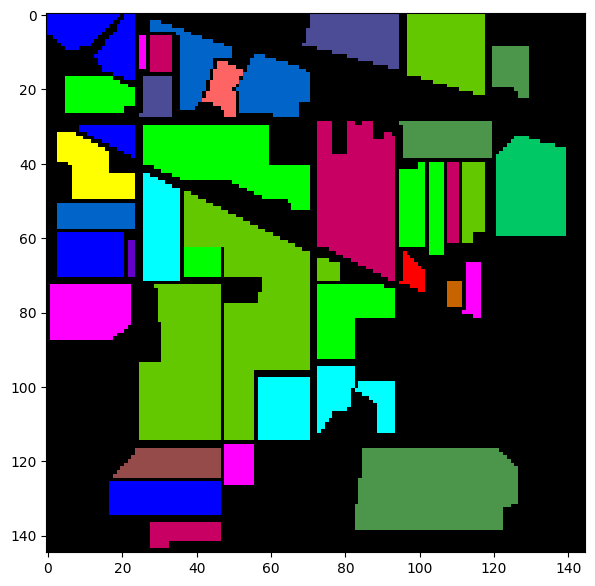

In [41]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

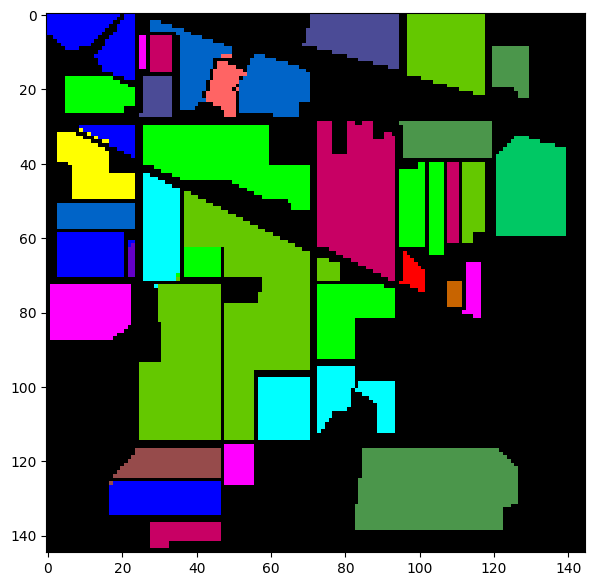

In [42]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [43]:
spectral.save_rgb(str(dataset)+"_"+str(test_ratio)+"_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [44]:
spectral.save_rgb(str(dataset)+"_"+str(test_ratio)+"_gt.jpg", y, colors=spectral.spy_colors)

#SON